In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%run phasedecoder907.ipynb
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import math
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/3-lemons919__session.pkl', 'rb') as inp:
    lem919_session = pickle.load(inp)
lem919_rates = lem919_session.data['rates']
lem919_angles = lem919_session.data['angles']
lem919_coords = lem919_session.data['coords']

with open('/mnt/c/oobootoo/rat-fes/data/pickles/3-meepo919__session.pkl', 'rb') as inp:
    mep919_session = pickle.load(inp)
mep919_rates = mep919_session.data['rates']
mep919_angles = mep919_session.data['angles']
mep919_coords = mep919_session.data['coords']



In [7]:
lem919arctans, lem919phase_list, lem919H_sin, lem919H_cos, lem919r, sin_array, cos_array, predicted_sin, predicted_cos = phase_train(lem919_rates, lem919_angles)
lem919tsf = np.linspace(0, (lem919phase_list.shape[0]*50)/1000,lem919phase_list.shape[0])

mep919arctans, mep919phase_list, mep919H_sin, mep919H_cos, mep919r, sin_array, cos_array, predicted_sin, predicted_cos = phase_train(mep919_rates, mep919_angles)
mep919tsf = np.linspace(0, (mep919phase_list.shape[0]*50)/1000,mep919phase_list.shape[0])



In [8]:
print(mep919r)
print(lem919r)

[0.35141279581275553, 0.47049385234104923, 0.27610625974628905, 0.36206442956279744, 0.35915524236585333, 0.25827966583592016, 0.34791929062861887]
[0.3380745949579333, 0.535786389596543, 0.3250383664331365, 0.36918004648657987, 0.3423044348416109, 0.24172095341155336, 0.3589107098249399]


<bound method Figure.tight_layout of <Figure size 1200x1600 with 6 Axes>>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
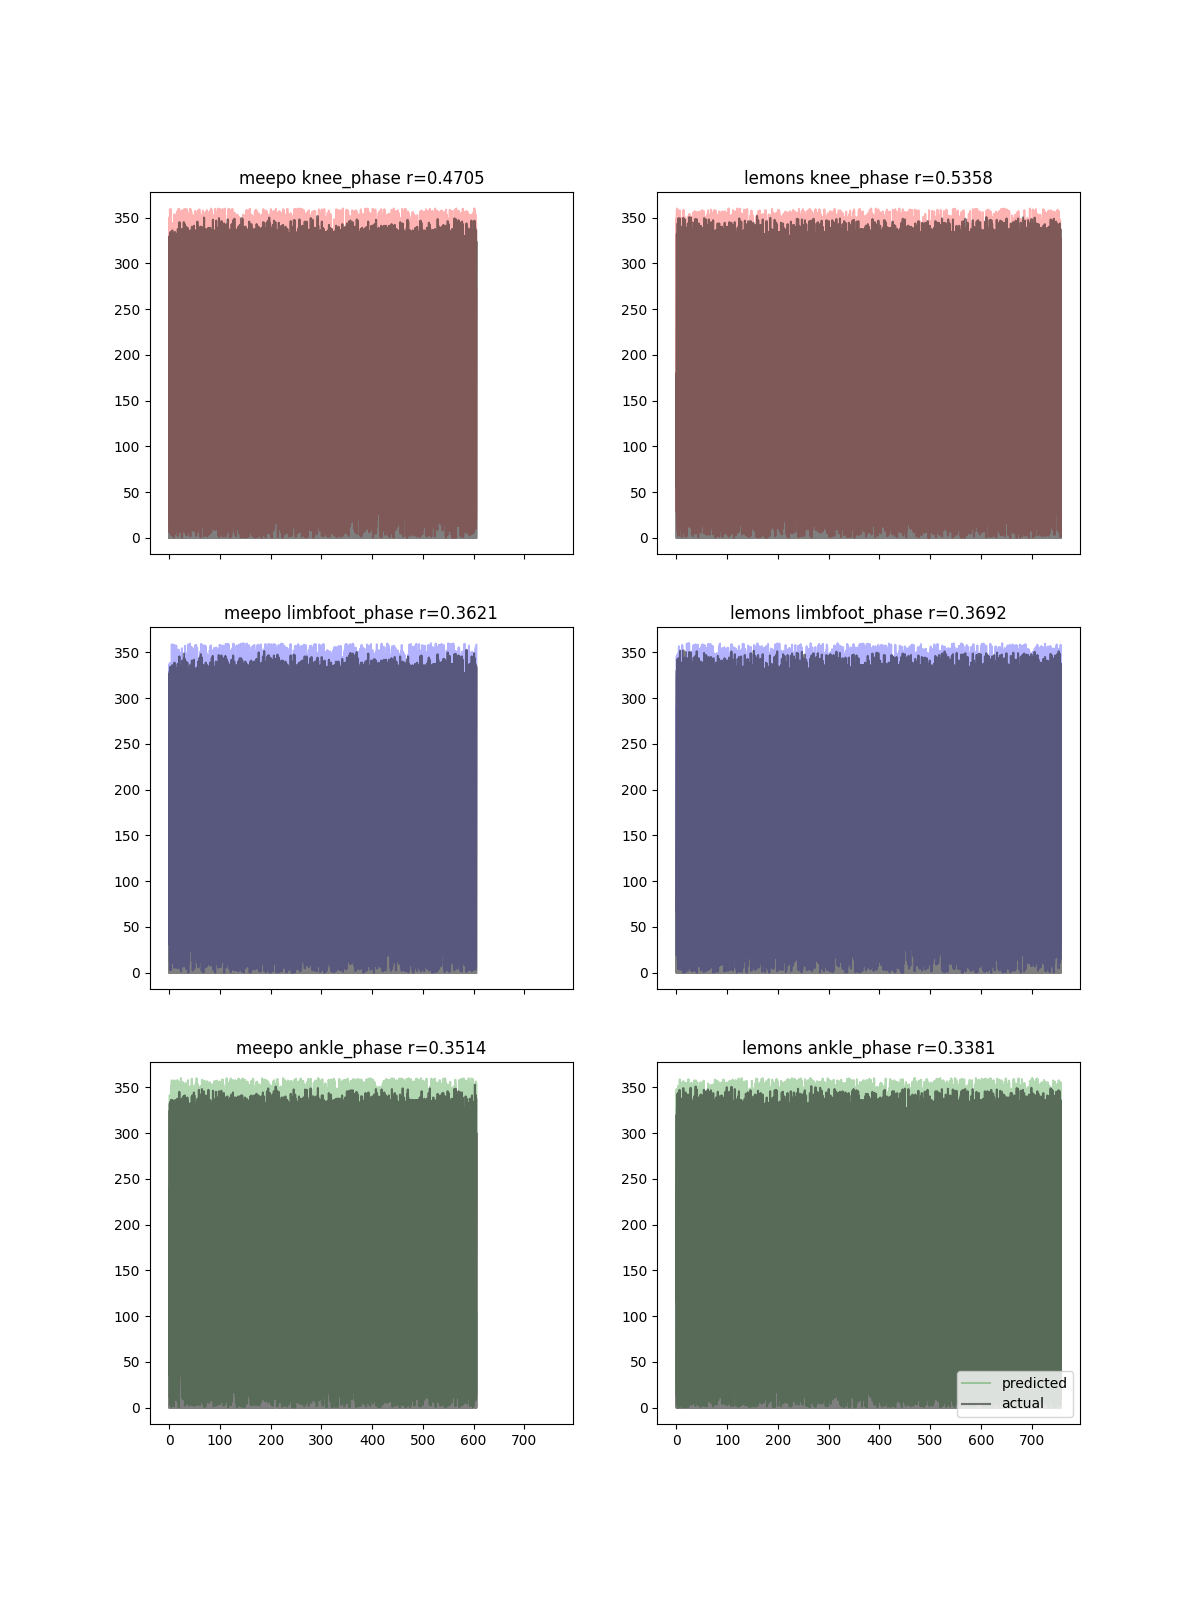

In [10]:
fig512, ax = plt.subplots(3,2, figsize=(12,16), sharex = True)
ax[0,0].set_title('meepo knee_phase r=' + f'{mep919r[1]:.{4}f}')
ax[0,0].plot(mep919tsf, mep919arctans[:,1], c='r', alpha=0.3, label = "predicted")
ax[0,0].plot(mep919tsf, mep919phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[0,1].set_title('lemons knee_phase r=' + "{0:.4f}".format(lem919r[1]))
ax[0,1].plot(lem919tsf, lem919arctans[:,1], c='r', alpha=0.3, label = "predicted")
ax[0,1].plot(lem919tsf, lem919phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[1,0].set_title('meepo limbfoot_phase r=' + f'{mep919r[3]:.{4}f}')
ax[1,0].plot(mep919tsf, mep919arctans[:,3], c='b', alpha=0.3, label = "predicted")
ax[1,0].plot(mep919tsf, mep919phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[1,1].set_title('lemons limbfoot_phase r=' + "{0:.4f}".format(lem919r[3]))
ax[1,1].plot(lem919tsf, lem919arctans[:,3], c='b', alpha=0.3, label = "predicted")
ax[1,1].plot(lem919tsf, lem919phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[2,0].set_title('meepo ankle_phase r=' + f'{mep919r[0]:.{4}f}')
ax[2,0].plot(mep919tsf, mep919arctans[:,0], c='g', alpha=0.3, label = "predicted")
ax[2,0].plot(mep919tsf, mep919phase_list[:,0], c='k', alpha=0.5, label = "actual")
ax[2,1].set_title('lemons ankle_phase r=' + "{0:.4f}".format(lem919r[0]))
ax[2,1].plot(lem919tsf, lem919arctans[:,0], c='g', alpha=0.3, label = "predicted")
ax[2,1].plot(lem919tsf, lem919phase_list[:,0], c='k', alpha=0.5, label = "actual")
ax[2,1].legend(loc="lower right")
fig512.tight_layout

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
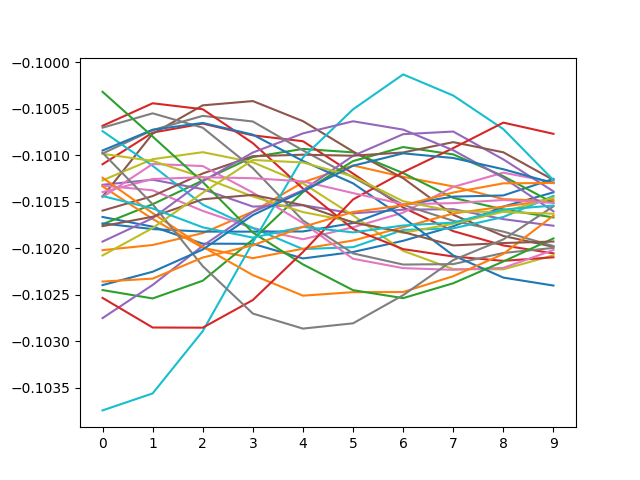

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
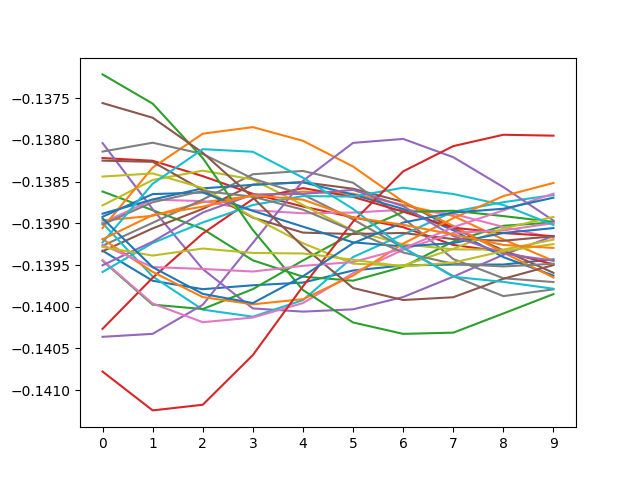

In [11]:
impulse_response(mep919H_cos, 1)
impulse_response(lem919H_cos, 1)